In [1]:
import numpy as np
import pickle
import pandas as pd
from collections import Counter
from source.models import Models
from source.morph import Morph
from source.tsmorph import TSmorph
from sklearn.metrics import accuracy_score
import time
from source.mitbhi_dataset import MITBIHDataset
from sklearn.model_selection import GroupShuffleSplit
import warnings
warnings.filterwarnings('ignore')

### Load Processed MIT-BIH Arrhythmia Dataset 

In [2]:
# Import the class
from source.mitbhi_dataset import MITBIHDataset, SUBJECTS

X, y, s = MITBIHDataset(subsets=["N", "L"], lead_index=1, ).load_data()

HEARTBEAT_CLASS_MAPPING = {
    0: "Normal",
    1: "Left Bundle Branch Block (LBBB)",
}

# reshape the data to (n,1,m)
X = X.reshape(X.shape[0], 1, X.shape[1])
print(X.shape)
# X: ECG segments (features)
# y: Labels (AAMI classes)
# s: Subject IDs

2025-03-19 15:12:52.441 | DEBUG    | source.mitbhi_dataset:_construct_individual_trial:144 - ['+' 'N' 'N' ... 'N' 'N' 'N']
2025-03-19 15:12:52.465 | WARNING  | source.mitbhi_dataset:_construct_individual_trial:169 - Sample discarded due to incorrect beat length.
2025-03-19 15:12:52.470 | WARNING  | source.mitbhi_dataset:_construct_individual_trial:169 - Sample discarded due to incorrect beat length.
2025-03-19 15:12:52.761 | DEBUG    | source.mitbhi_dataset:_construct_individual_trial:144 - ['+' 'N' 'N' ... 'N' 'N' 'N']
2025-03-19 15:12:52.783 | WARNING  | source.mitbhi_dataset:_construct_individual_trial:169 - Sample discarded due to incorrect beat length.
2025-03-19 15:12:52.941 | DEBUG    | source.mitbhi_dataset:_construct_individual_trial:144 - ['+' '/' '/' ... '/' '/' '/']
2025-03-19 15:12:53.062 | DEBUG    | source.mitbhi_dataset:_construct_individual_trial:144 - ['+' 'N' 'N' ... 'N' 'N' 'N']
2025-03-19 15:12:53.220 | DEBUG    | source.mitbhi_dataset:_construct_individual_trial:1

(83106, 1, 180)


In [5]:
# dataset =  MITBIHDataset(subsets=["N", "L"], lead_index=1).load_data()
# X, y, s = dataset.load_data()

# # reshape the data to (n,1,m)
# X = X.reshape(X.shape[0], 1, X.shape[1])

In [3]:
np.random.seed(0)
random_index = np.random.choice(range(X.shape[0]), 11000, replace=False)
X = X[random_index]
y = y[random_index]
s = s[random_index]

splitter = GroupShuffleSplit(test_size=0.1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, s))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [4]:
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print(np.unique(y_train, return_counts=True))

X_train Shape: (9620, 1, 180)
X_test Shape: (1380, 1, 180)
(array([0, 1]), array([8747,  873], dtype=int64))


In [7]:
# separate classes 
X_train_classes = []
y_train_classes = []
for i in range(2):
    X_train_classes.append(X_train[y_train == i])
    y_train_classes.append(y_train[y_train == i])

## Different Classes

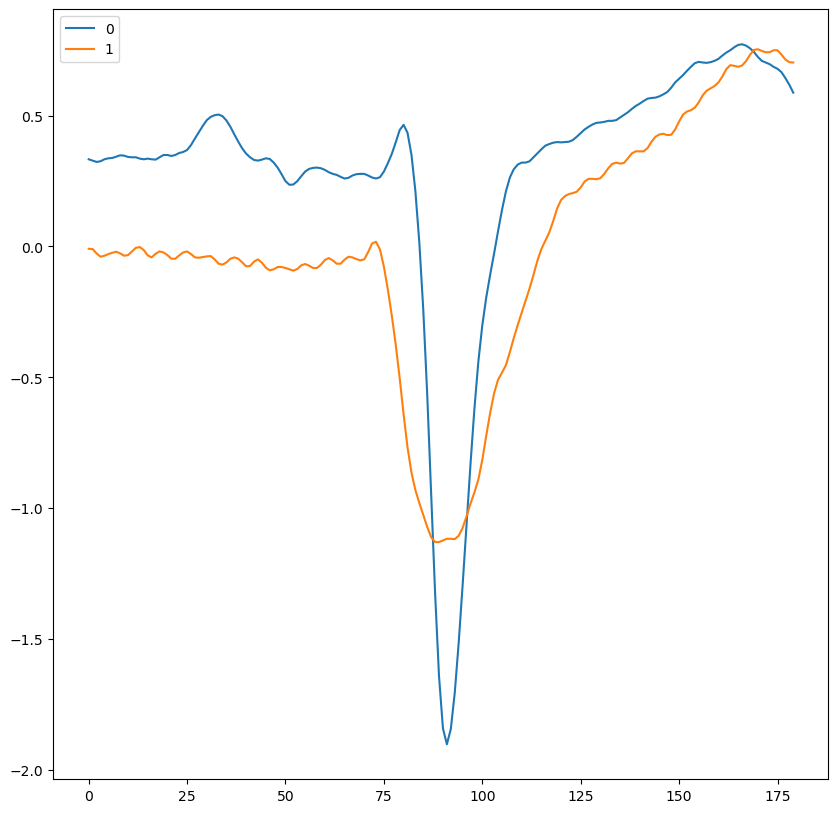

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(len(X_train_classes)):
    plt.plot(X_train_classes[i][0].T, label=i)

plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from source.DBA import performDBA
import numpy as np
import matplotlib.pyplot as plt

def getDBA(X_morph, y_morph, plot=False):
    # Get unique classes
    classes = np.unique(y_morph)
    n_classes = len(classes)
    
    if n_classes < 2:
        print("Error: There should be at least two classes.")
        return None
    
    # Separate X_morph by class
    X_by_class = [X_morph[y_morph == cls].squeeze(axis=1) for cls in classes]
    
    # Compute DBA for each class
    centers = np.array([performDBA(X_class[:50]) for X_class in X_by_class])
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Define a color palette for the classes
        colors = plt.cm.tab10.colors 
        
        for i, (X_class, cls) in enumerate(zip(X_by_class, classes)):
            # for s in X_class:
            #     plt.plot(s, color=colors[i], alpha=0.3, linewidth=1, label='_')
            plt.plot(centers[i].flatten(), color=colors[i], linewidth=2, label=f'Class {cls} Average')
        
        # Add labels and title
        plt.xlabel('Time Steps', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.title('Time Series by Class with DBA Averages', fontsize=14, pad=15)
        
        # Add grid and legend
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        
        # Adjust layout
        plt.tight_layout()
        plt.show()
    
    return centers

In [10]:
getDBA(X_test, y_test, plot=True)

KeyboardInterrupt: 

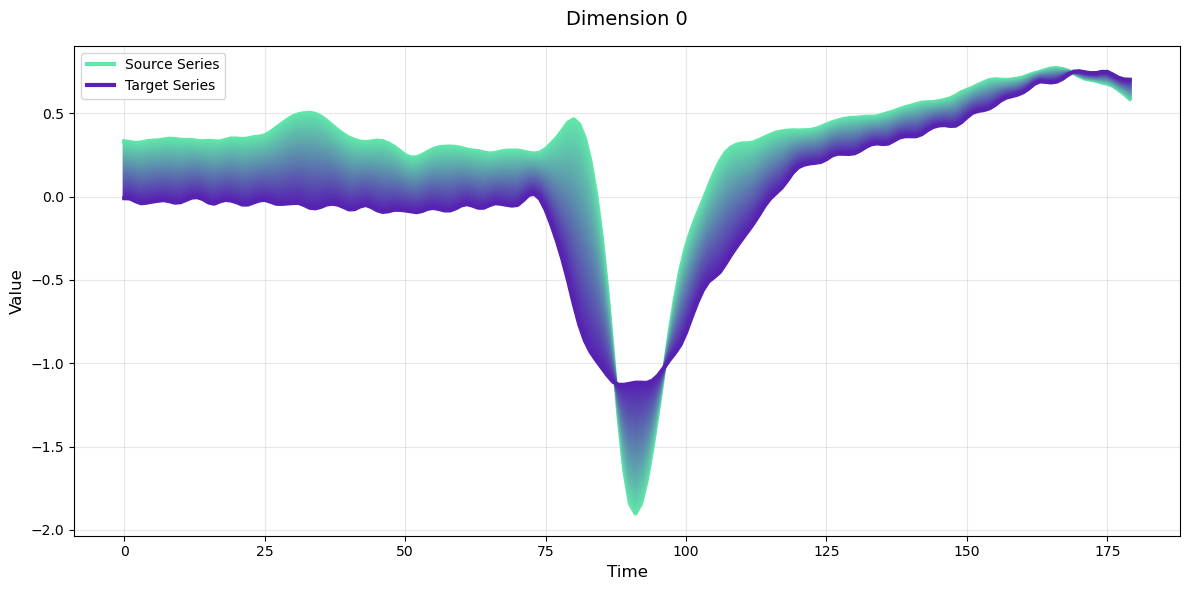

In [11]:
S = X_train_classes[0][0]
T = X_train_classes[1][0]

morph = TSmorph(S, T, 100)
mor = morph.transform()

morph.plot_morphed_series(mor)

In [18]:
# Train Models
start = time.time()
lstm = Models('lstm', X_train, y_train)
lstm.train_lstm()
end1 = time.time()
print("LSTM Training Time:", end1 - start)

catch = Models('catch22', X_train, y_train)
catch.train_catch22()
end2 = time.time()
print("Catch22 Training Time:", end2 - end1)

rocket = Models('rocket', X_train, y_train)
rocket.train_rocket()
end3 = time.time()
print("Rocket Training Time:", end3 - end2)

LSTM Training Time: 401.3827483654022
Catch22 Training Time: 19.702824354171753
Rocket Training Time: 383.0904905796051


In [25]:
models = (lstm, catch, rocket)
res = {}
acc = {}

for model in models:
    y_pred,_ = model.predict(X_test)
    res[model.model_name] = y_pred
    acc[model.model_name] = accuracy_score(y_test, y_pred)

    print(f"Model: {model.model_name} Accuracy: {accuracy_score(y_test, y_pred)}") 
    print(res[model.model_name])

# print difference in results
for model in models:
    for model2 in models:
        if model.model_name != model2.model_name:
            print(f"{model.model_name} vs {model2.model_name}")
            print(np.sum(res[model.model_name] == res[model2.model_name]))

Model: lstm Accuracy: 0.855072463768116
[0 0 0 ... 0 0 0]
Model: catch22 Accuracy: 0.855072463768116
[0 0 0 ... 0 0 0]
Model: rocket Accuracy: 0.855072463768116
[0 0 0 ... 0 0 0]
lstm vs catch22
1380
lstm vs rocket
1380
catch22 vs lstm
1380
catch22 vs rocket
1380
rocket vs lstm
1380
rocket vs catch22
1380


In [ ]:
# Perform morphing calculations
mor = Morph(X_test, y_test, np.unique(y_test)[0])
mor.get_DTWGlobalBorderline(perc_samples=0.01)

In [33]:
# save pairs to pkl
with open('data/DTWGlobalBorderline.pkl', 'wb') as f:
    pickle.dump(mor.allborderline, f)

IndexError: list index out of range

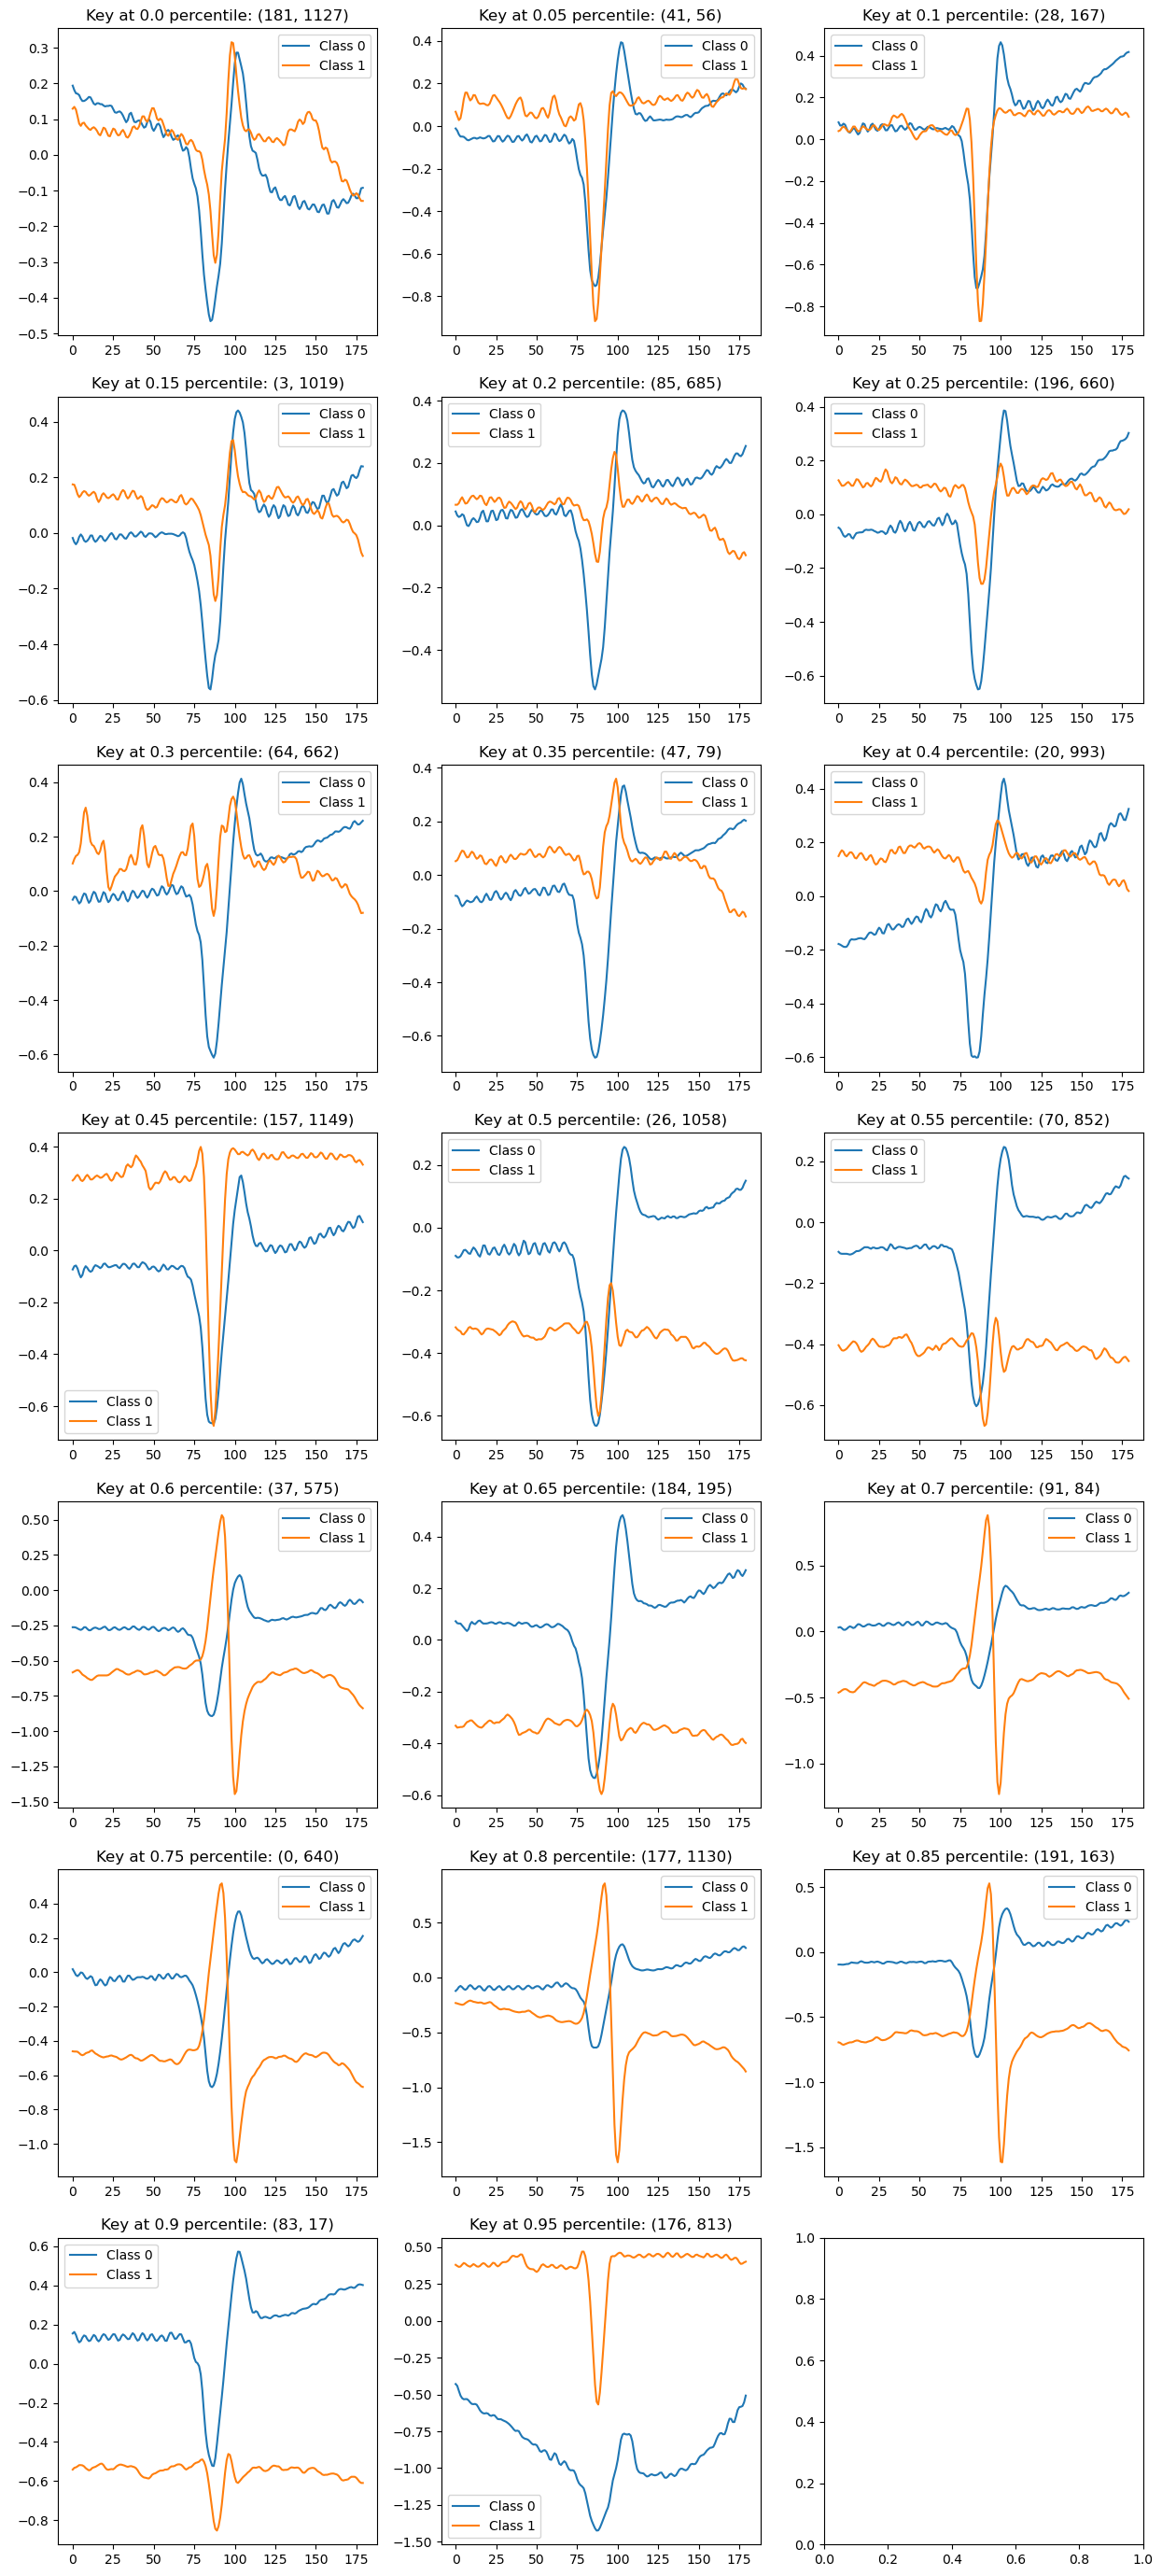

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_key_at_percentile(data, percentile):
    # Extract values and sort them
    sorted_values = sorted(data.values())
    
    # Calculate the value at the given percentile
    percentile_value = sorted_values[int(round(len(sorted_values) * percentile))]
    
    # Find the key whose value is closest to the percentile value
    closest_key = min(data.keys(), key=lambda k: abs(data[k] - percentile_value))
    
    return closest_key

pairs = mor.allborderline
class0 = mor.class0_X
class1 = mor.class1_X

# Define bins
bins = np.arange(0, 1.01, 0.05)

# Create a figure with subplots
num_bins = len(bins)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_bins + num_cols - 1) // num_cols  # Calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot for each bin
for i, b in enumerate(bins):
    key = get_key_at_percentile(pairs, b)

    # Plot Class 0 and Class 1
    axes[i].plot(class0[key[0]].T, label='Class 0')
    axes[i].plot(class1[key[1]].T, label='Class 1')
    axes[i].legend()
    axes[i].set_title(f"Key at {b:.2} percentile: {key}")

# Hide unused subplots
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [63]:
df_name = 'MITBIH'

# Initialize variables to store results
results_array = np.empty((0, 10)) 
results = {}

# Save Dataset Features
ts_length = X_train.shape[2]
df_size = X_train.shape[0]
n_classes = len(np.unique(y))  
class_counts = Counter(y_train)
num_classes = len(class_counts)

# Evaluate models
models = [lstm, catch, rocket]
acc = {}
for m in models:
    pred, _ = m.predict(X_test)
    acc[m.model_name] = accuracy_score(pred, y_test)

# Loop through each class
for c in np.unique(y):
    start_class = time.time()
    print(f'Processing Class: {c}')

    # Calculate class percentage
    class_perc = round(class_counts[c] / df_size, 3)

    # Perform morphing calculations
    mor = Morph(X_test, y_test, c)
    mor.get_DTWGlobalBorderline(perc_samples=0.01)
    res = mor.Binary_MorphingCalculater(models)

    end_class = time.time()
    print(f'Total Class {c} run time: {end_class - start_class}')

    # Store results for the class
    results[c] = res

    # Append results to NumPy array
    for model in res.keys():
        data = res[model]['metrics']
        line = np.array([[df_name, df_size, ts_length, n_classes, c, class_perc, model, data['mean'], data['std'], acc[model]]])
        results_array = np.vstack((results_array, line))
        

# Save results for the current dataset
file_name = f'results/pickles/{df_name}.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(results, f)

# Clean ups
del models, catch, results

# Convert NumPy array to Pandas DataFrame
columns = ['dataset', 'df_size', 'ts_length', 'n_classes', 'class', 'class_perc', 'model', 'mean', 'std', 'model_acc']
dataframe = pd.DataFrame(results_array, columns=columns)
# Save results to CSV
dataframe.to_csv('results/use_case.csv', index=False)

Processing Class: 0


  3%|▎         | 76/2360 [11:49<5:55:29,  9.34s/it] 


KeyboardInterrupt: 

In [1]:
# load results 
file_name = f'results/pickles/MITBIH.pkl'
with open(file_name, 'rb') as f:
    results = pickle.load(f)

NameError: name 'pickle' is not defined